## Target Trial Emulation R code conversion to Python

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
import statsmodels.api as sm

### 2. Process data: compute weights, prepare survival data

In [3]:
data = pd.read_csv('dataset/data_censored.csv')

def process_estimand(data, estimand_type):
    if estimand_type == 'PP':
        # Treatment (switch) model only for PP
        eligible_data = data[data['eligible'] == 1].copy()
        
        # Fit numerator and denominator models for treatment
        numerator_model = smf.glm('treatment ~ age', eligible_data, 
                                  family=sm.families.Binomial()).fit()
        denominator_model = smf.glm('treatment ~ age + x1 + x3', eligible_data, 
                                    family=sm.families.Binomial()).fit()
        
        # Predict treatment probabilities
        eligible_data['num_prob_tx'] = numerator_model.predict(eligible_data)
        eligible_data['denom_prob_tx'] = denominator_model.predict(eligible_data)
        
        # Compute stabilized treatment weights
        eligible_data['tx_num'] = np.where(eligible_data['treatment'] == 1,
                                           eligible_data['num_prob_tx'],
                                           1 - eligible_data['num_prob_tx'])
        eligible_data['tx_denom'] = np.where(eligible_data['treatment'] == 1,
                                             eligible_data['denom_prob_tx'],
                                             1 - eligible_data['denom_prob_tx'])
        eligible_data['sw_weight'] = eligible_data['tx_num'] / eligible_data['tx_denom']
        
        # Merge back to original data and set missing weights to 1
        sw_weights = eligible_data[['id', 'period', 'sw_weight']]
        data_processed = pd.merge(data, sw_weights, on=['id', 'period'], how='left')
        data_processed.loc[:, 'sw_weight'] = data_processed['sw_weight'].fillna(1)
    else:
        data_processed = data.copy()
        data_processed['sw_weight'] = 1  # No treatment weighting for ITT
    
    # Censoring models: fit numerator and denominator models for censoring
    numerator_formula = 'censored ~ x2'
    denominator_formula = 'censored ~ x2 + x1'
    censor_num_model = smf.glm(numerator_formula, data_processed,
                               family=sm.families.Binomial()).fit()
    censor_denom_model = smf.glm(denominator_formula, data_processed,
                                 family=sm.families.Binomial()).fit()
    
    # Predict censoring probabilities
    data_processed['num_prob_censor'] = censor_num_model.predict(data_processed)
    data_processed['denom_prob_censor'] = censor_denom_model.predict(data_processed)
    
    # Compute censoring weights
    data_processed['cw_num'] = np.where(data_processed['censored'] == 1,
                                        data_processed['num_prob_censor'],
                                        1 - data_processed['num_prob_censor'])
    data_processed['cw_denom'] = np.where(data_processed['censored'] == 1,
                                          data_processed['denom_prob_censor'],
                                          1 - data_processed['denom_prob_censor'])
    data_processed['cw_weight'] = data_processed['cw_num'] / data_processed['cw_denom']
    
    # Compute cumulative weights over periods
    data_sorted = data_processed.sort_values(['id', 'period'])
    data_sorted['cum_sw'] = data_sorted.groupby('id')['sw_weight'].cumprod()
    data_sorted['cum_cw'] = data_sorted.groupby('id')['cw_weight'].cumprod()
    data_sorted['cum_weight'] = data_sorted['cum_sw'] * data_sorted['cum_cw']
    
    # Drop periods after censoring
    data_sorted['censored_ever'] = data_sorted.groupby('id')['censored'].cummax()
    data_filtered = data_sorted[data_sorted['censored_ever'] == 0].copy()
    
    # Winsorize weights at the 99th percentile
    q99 = data_filtered['cum_weight'].quantile(0.99)
    data_filtered.loc[:, 'cum_weight_win'] = np.minimum(data_filtered['cum_weight'], q99)
    
    # Prepare for survival analysis:
    data_filtered.loc[:, 'start'] = data_filtered['period']
    data_filtered.loc[:, 'stop'] = data_filtered['period'] + 1
    data_filtered.loc[:, 'event'] = data_filtered['outcome']
    
    # Mimic trial expansion: assigned_treatment equals treatment
    data_filtered.loc[:, 'assigned_treatment'] = data_filtered['treatment']
    
    return data_filtered

# Process data (here we use ITT; similar for PP)
itt_data = process_estimand(data, 'ITT')


In [4]:
cph = CoxPHFitter()
cph.fit(itt_data, duration_col='stop', event_col='event', entry_col='start',
        weights_col='cum_weight_win', formula="treatment + x2", robust=True)
print(cph.print_summary())

model,lifelines.CoxPHFitter
duration col,'stop'
event col,'event'
weights col,'cum_weight_win'
entry col,'start'
robust variance,True
baseline estimation,breslow
number of observations,663.896
number of events observed,9.16579
partial log-likelihood,-29.08
time fit was run,2025-03-09 12:34:10 UTC


None


### 4. Predict survival functions for a reference Control and Treatment subject

In [5]:
# Fix x2 to its mean value
x2_mean = itt_data['x2'].mean()
df_control = pd.DataFrame({'treatment': [0], 'x2': [x2_mean]})
df_treatment = pd.DataFrame({'treatment': [1], 'x2': [x2_mean]})

pred_times = np.arange(0, 11)

# Predict survival functions without CI since your lifelines version does not support include_ci
sf_control = cph.predict_survival_function(df_control, times=pred_times)
sf_treatment = cph.predict_survival_function(df_treatment, times=pred_times)

# For demonstration, we now only have point estimates.
# (To get CI, update lifelines to version 0.27.0+ or compute manually.)
sf_control_point = sf_control.iloc[:, 0]
sf_treatment_point = sf_treatment.iloc[:, 0]

### 5. Compute the survival difference (Treatment - Control)

In [6]:
diff = sf_treatment_point - sf_control_point

### 6. Plot the survival difference (point estimates only)

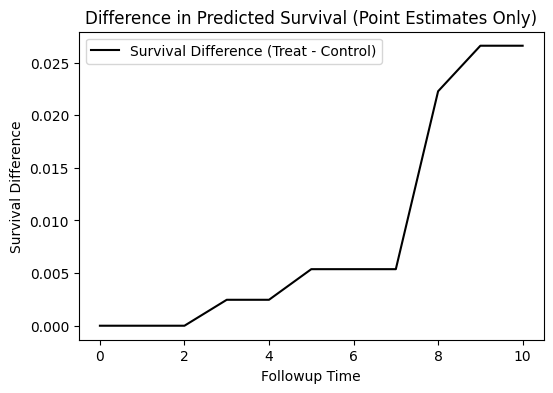

In [7]:
# ======================================================
# 6. Plot the survival difference (point estimates only)
# ======================================================
plt.figure(figsize=(6,4))
plt.plot(pred_times, diff, 'k-', label="Survival Difference (Treat - Control)")
plt.xlabel("Followup Time")
plt.ylabel("Survival Difference")
plt.title("Difference in Predicted Survival (Point Estimates Only)")
plt.legend()
plt.show()